In [ ]:
# You only need to run this once per machine
#!pip install -q -U bitsandbytes
#!pip install -q -U git+https://github.com/huggingface/transformers.git
#!pip install -q -U git+https://github.com/huggingface/peft.git
#!pip install -q -U git+https://github.com/huggingface/accelerate.git
#!pip install -q -U datasets scipy ipywidgets matplotlib

### 0. Accelerator

In [1]:
from accelerate import FullyShardedDataParallelPlugin, Accelerator
from torch.distributed.fsdp.fully_sharded_data_parallel import FullOptimStateDictConfig, FullStateDictConfig

fsdp_plugin = FullyShardedDataParallelPlugin(
    state_dict_config=FullStateDictConfig(offload_to_cpu=True, rank0_only=False),
    optim_state_dict_config=FullOptimStateDictConfig(offload_to_cpu=True, rank0_only=False),
)

accelerator = Accelerator(fsdp_plugin=fsdp_plugin)

### 1. Load Dataset

#### Preparing data

In [2]:
from datasets import load_dataset
train_dataset = load_dataset('json', data_files='./Datasets/low_elo_4287_games_training_engine_nosco_noseq.jsonl', split='train')
eval_dataset = load_dataset('json', data_files='./Datasets/low_elo_4287_games_val_engine_nosco_noseq.jsonl', split='train')
print(train_dataset[1]["input"])

hello
Current Position: white has no pawn
white has no knight
white has no bishop
white has no rook
white has 1 queen on: f7
white has 1 king on: f3
black has no pawn
black has no knight
black has no bishop
black has no rook
black has no queen
black has 1 king on: g5

White to move.
Legal Moves: Qg8+, Qf8, Qe8, Qh7, Qg7+, Qe7+, Qd7, Qc7, Qb7, Qa7, Qe6, Qd5+, Qf4+, Qc4, Qb3, Qa2, Ke4, Kg3, Ke3, Kg2, Kf2, Ke2, Qg6+, Qf6+, Qh5+, Qf5+


In [4]:
def formatting_func(example):
    text = f"### Using the current position and legal moves provided, predict a human move that an intermediate chess player would make. Always use the list of legal moves which are ordered from best to worst:\n{example['input']}\n\n### Answer: {example['output']}\n###"
    return text

In [5]:
print(formatting_func(train_dataset[1]))

### Using the current position and legal moves provided, predict a human move that an intermediate chess player would make. Always use the list of legal moves which are ordered from best to worst:
Current Position: white has no pawn
white has no knight
white has no bishop
white has no rook
white has 1 queen on: f7
white has 1 king on: f3
black has no pawn
black has no knight
black has no bishop
black has no rook
black has no queen
black has 1 king on: g5

White to move.
Legal Moves: Qg8+, Qf8, Qe8, Qh7, Qg7+, Qe7+, Qd7, Qc7, Qb7, Qa7, Qe6, Qd5+, Qf4+, Qc4, Qb3, Qa2, Ke4, Kg3, Ke3, Kg2, Kf2, Ke2, Qg6+, Qf6+, Qh5+, Qf5+

### Answer: Ke3
###


### 2. Load Base Model

In [6]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "mistralai/Mistral-7B-v0.1"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(base_model_id, quantization_config=bnb_config)

bin C:\Users\liamd\AppData\Local\Programs\Python\Python311\Lib\site-packages\bitsandbytes\libbitsandbytes_cuda118.dll


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

### 3. Tokenization

In [7]:
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
)
tokenizer.pad_token = tokenizer.eos_token

def generate_and_tokenize_prompt(prompt):
    return tokenizer(formatting_func(prompt))

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Reformat the prompt and tokenize each sample:

In [8]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt)

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Let's get a distribution of our dataset lengths, so we can determine the appropriate `max_length` for our input tensors.

10300


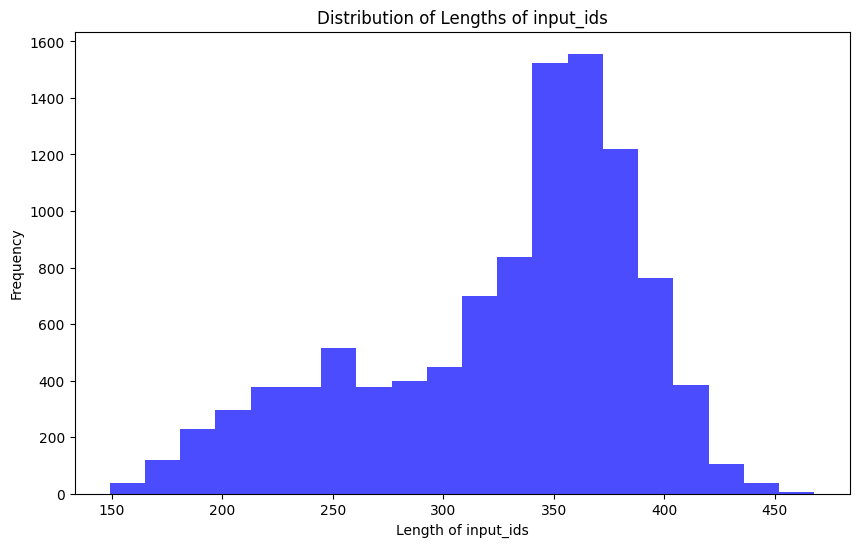

In [9]:
import matplotlib.pyplot as plt

def plot_data_lengths(tokenize_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    lengths += [len(x['input_ids']) for x in tokenized_val_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

In [10]:
max_length = 448 # This was an appropriate max length for my dataset

def generate_and_tokenize_prompt2(prompt):
    result = tokenizer(
        formatting_func(prompt),
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

In [11]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt2)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt2)

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Check that `input_ids` is padded on the left with the `eos_token` (2) and there is an `eos_token` 2 added to the end, and the prompt starts with a `bos_token` (1).

In [10]:
#print(tokenized_train_dataset[1]['input_ids'])

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 5938, 574, 4788, 302, 997, 819, 12108, 28725, 4783, 380, 5537, 298, 7655, 20364, 28742, 28713, 2572, 21319, 304, 285, 3626, 454, 298, 12595, 380, 2572, 8928, 28723, 13399, 28725, 272, 5541, 349, 298, 1877, 15356, 272, 20364, 28742, 28713, 6779, 28725, 579, 1012, 5161, 1023, 4216, 333, 298, 5009, 5083, 369, 5541, 1312, 20533, 574, 7769, 28723, 995, 460, 865, 4670, 298, 9421, 395, 272, 1679, 2318, 28723, 13, 2733

Now all the samples should be the same length, `max_length`.

10300


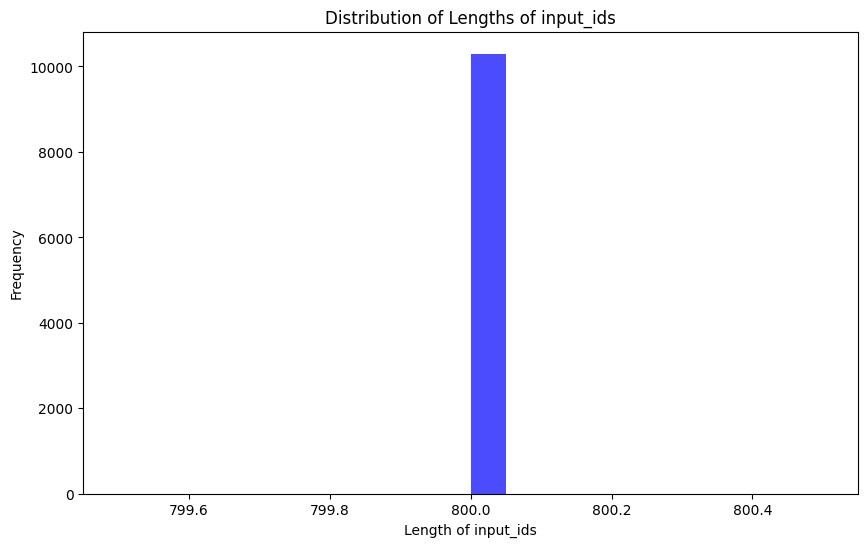

In [11]:
#plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

### How does the base model do?

In [12]:
eval_prompt = """ ### Predict what a low ELO chess player would play given this information:
Game Sequence: ['e4', 'c5']
White to move.
Legal Moves: ['Nh3', 'Nf3', 'Ne2', 'Ba6', 'Bb5', 'Bc4', 'Bd3', 'Be2', 'Ke2', 'Qh5', 'Qg4', 'Qf3', 'Qe2', 'Nc3', 'Na3', 'e5', 'h3', 'g3', 'f3', 'd3', 'c3', 'b3', 'a3', 'h4', 'g4', 'f4', 'd4', 'c4', 'b4', 'a4']
### Answer:
"""

In [13]:
model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
    print(tokenizer.decode(model.generate(**model_input, max_new_tokens=256, pad_token_id=2)[0], skip_special_tokens=True))

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


 ### Predict what a low ELO chess player would play given this information:
Game Sequence: ['e4', 'c5']
White to move.
Legal Moves: ['Nh3', 'Nf3', 'Ne2', 'Ba6', 'Bb5', 'Bc4', 'Bd3', 'Be2', 'Ke2', 'Qh5', 'Qg4', 'Qf3', 'Qe2', 'Nc3', 'Na3', 'e5', 'h3', 'g3', 'f3', 'd3', 'c3', 'b3', 'a3', 'h4', 'g4', 'f4', 'd4', 'c4', 'b4', 'a4']
### Answer:
м
### Explanation:
The game sequence is e4 and c5, which means that white has moved their pawn to e4 and black has moved their pawn to c5.

White has the following legal moves: Nh3, Nf3, Ne2, Ba6, Bb5, Bc4, Bd3, Be2, Ke2, Qh5, Qg4, Qf3, Qe2, Nc3, Na3, e5, h3, g3, f3, d3, c3, b3, a3, h4, g4, f4, d4, c4, b4, a4.

Given this information, a low ELO chess player would likely play the move Na3. This move is a defensive move that protects the king from attack and also prepares for future attacks on the opponent's pieces.

### Predict what a high ELO chess player would play given this information:
Game Sequence: ['e4', 'c5']
White to move.
Legal Moves: ['Nh3',

Observe how the model does out of the box.

### 4. Set Up LoRA

In [12]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [13]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

Let's print the model to examine its layers, as we will apply QLoRA to all the linear layers of the model. Those layers are `q_proj`, `k_proj`, `v_proj`, `o_proj`, `gate_proj`, `up_proj`, `down_proj`, and `lm_head`.

In [14]:
print(model)

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm): MistralRMSNorm()
      )

In [15]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head",
    ],
    bias="none",
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

# Apply the accelerator.
model = accelerator.prepare_model(model)

trainable params: 85041152 || all params: 3837112320 || trainable%: 2.2162799758751914


In [16]:
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): MistralForCausalLM(
      (model): MistralModel(
        (embed_tokens): Embedding(32000, 4096)
        (layers): ModuleList(
          (0-31): 32 x MistralDecoderLayer(
            (self_attn): MistralAttention(
              (q_proj): Linear4bit(
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
              )
              (k_proj): Linear4bit(
                (lora_dropout): ModuleDict(

In [17]:
import wandb, os
wandb.login()

wandb_project = "chess-v08-finetune"
if len(wandb_project) > 0:
    os.environ["WANDB_PROJECT"] = wandb_project

wandb: Currently logged in as: liamd. Use `wandb login --relogin` to force relogin


### 5. Run Training!

In [28]:
# for resuming training without retraining tokens
# tokenized_train_dataset = tokenized_train_dataset[4000:]

In [18]:
if torch.cuda.device_count() > 1: # If more than 1 GPU
    model.is_parallelizable = True
    model.model_parallel = True

In [20]:
import transformers
from datetime import datetime

################### change the name of the model here ###################
project = "journal-finetune"
base_model_name = "mistral"
run_name = base_model_name + "-" + project
output_dir = "./" + run_name

tokenizer.pad_token = tokenizer.eos_token

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        warmup_steps=1,
        per_device_train_batch_size=2,
        gradient_accumulation_steps=1,
        max_steps=2500,
        learning_rate=5e-5, #2.5e-5, # Want a small lr for finetuning
        bf16=True,
        optim="paged_adamw_8bit",
        logging_steps=100,              # When to start reporting loss
        logging_dir="./logs",        # Directory for storing logs
        save_strategy="steps",       # Save the model checkpoint every logging step
        save_steps=100,                # Save checkpoints every n steps
        evaluation_strategy="steps", # Evaluate the model every logging step
        eval_steps=100,               # Evaluate and save checkpoints every n steps
        do_eval=True,                # Perform evaluation at the end of training
        report_to="wandb",           # Comment this out if you don't want to use weights & baises
        run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}"          # Name of the W&B run (optional)
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

Step,Training Loss,Validation Loss
100,0.601900,0.518987
200,0.500400,0.492903
300,0.506500,0.476101
400,0.478900,0.456302
500,0.462400,0.450360
600,0.475400,0.442122
700,0.467400,0.442672
800,0.459200,0.433252
900,0.445300,0.430021
1000,0.439500,0.423097


C:\Users\liamd\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
C:\Users\liamd\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
C:\Users\liamd\AppData\L

TrainOutput(global_step=2500, training_loss=0.44036041259765624, metrics={'train_runtime': 12239.9488, 'train_samples_per_second': 0.408, 'train_steps_per_second': 0.204, 'total_flos': 9.671022477312e+16, 'train_loss': 0.44036041259765624, 'epoch': 0.5})

wandb: While tearing down the service manager. The following error has occurred: [WinError 10054] An existing connection was forcibly closed by the remote host


### 6. Load model


In [13]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import chess.engine

base_model_id = "mistralai/Mistral-7B-v0.1"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

In [14]:
base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,  # Mistral, same as before
    quantization_config=bnb_config,  # Same quantization config as before
    device_map="auto",
    trust_remote_code=True,
    use_auth_token=True
)

tokenizer = AutoTokenizer.from_pretrained(base_model_id, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token

C:\Users\liamd\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\models\auto\auto_factory.py:472: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\liamd\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\utils\hub.py:374: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [15]:
from peft import PeftModel

ft_model = PeftModel.from_pretrained(base_model, "mistral-journal-finetune/checkpoint-2500")

In [4]:
eval_prompt = """"Game Sequence:
['d4', 'e5', 'dxe5']
Current Position: white has 8 pawns on: a2,b2,c2,e2,f2,g2,h2,e5
white has 2 knights on: b1,g1
white has 2 bishops on: c1,f1
white has 2 rooks on: a1,h1
white has 1 queen on: d1
white has 1 king on: e1
black has 7 pawns on: a7,b7,c7,d7,f7,g7,h7
black has 2 knights on: b8,g8
black has 2 bishops on: c8,f8
black has 2 rooks on: a8,h8
black has 1 queen on: d8
black has 1 king on: e8

Black to move.
Legal Moves: ['Ne7', 'Nh6', 'Nf6', 'Be7', 'Bd6', 'Bc5', 'Bb4+', 'Ba3', 'Ke7', 'Qe7', 'Qf6', 'Qg5', 'Qh4', 'Nc6', 'Na6', 'h6', 'g6', 'f6', 'd6', 'c6', 'b6', 'a6', 'h5', 'g5', 'f5', 'd5', 'c5', 'b5', 'a5']

### Answer:"""

model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

In [5]:
ft_model.eval()
with torch.no_grad():
    print(tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=15, pad_token_id=2)[0], skip_special_tokens=True))

"Game Sequence: ['d4', 'e5', 'dxe5']
Current Position: white has 8 pawns on: a2,b2,c2,e2,f2,g2,h2,e5
white has 2 knights on: b1,g1
white has 2 bishops on: c1,f1
white has 2 rooks on: a1,h1
white has 1 queen on: d1
white has 1 king on: e1
black has 7 pawns on: a7,b7,c7,d7,f7,g7,h7
black has 2 knights on: b8,g8
black has 2 bishops on: c8,f8
black has 2 rooks on: a8,h8
black has 1 queen on: d8
black has 1 king on: e8

Black to move.
Legal Moves: ['Ne7', 'Nh6', 'Nf6', 'Be7', 'Bd6', 'Bc5', 'Bb4+', 'Ba3', 'Ke7', 'Qe7', 'Qf6', 'Qg5', 'Qh4', 'Nc6', 'Na6', 'h6', 'g6', 'f6', 'd6', 'c6', 'b6', 'a6', 'h5', 'g5', 'f5', 'd5', 'c5', 'b5', 'a5']
### Answer: d6
Game Sequence: ['d4', 'e5',


In [16]:
def fen_to_piece_description(fen):
    board = chess.Board(fen)
    piece_description = ""

    for color in [chess.WHITE, chess.BLACK]:
        for piece_type in [chess.PAWN, chess.KNIGHT, chess.BISHOP, chess.ROOK, chess.QUEEN, chess.KING]:
            pieces = list(board.pieces(piece_type, color))
            if pieces:
                piece_names = [chess.square_name(piece) for piece in pieces]
                piece_description += f"{chess.COLOR_NAMES[color]} has {len(pieces)} {chess.PIECE_NAMES[piece_type]}{'s' if len(pieces) > 1 else ''} on: {','.join(piece_names)}\n"
            else:
                piece_description += f"{chess.COLOR_NAMES[color]} has no {chess.PIECE_NAMES[piece_type]}\n"

    return piece_description

def get_legal_moves(moves):
    board = chess.Board()
    
    for move in moves:
        try:
            board.push_san(move)
        except ValueError:
            # Handle invalid moves
            return []

    legal_moves = [board.san(move) for move in board.legal_moves]
    return legal_moves

def whose_turn(moves):
    board = chess.Board()

    for move in moves:
        try:
            board.push_san(move)
        except ValueError:
            return None  # Invalid moves

    if board.turn == chess.WHITE:
        return "White to move."
    else:
        return "Black to move."

def convert_moves_to_board_state(moves):
    # Initialize a chess board
    board = chess.Board()

    # Loop through the moves and apply them to the board
    for move in moves:
        board.push_san(move)

    return board.fen()

def evaluate_moves(game_sequence, time_per_move=0.5):

    legal_moves = get_legal_moves(game_sequence)

    # Start the simple chess engine
    engine = chess.engine.SimpleEngine.popen_uci(r"D:\DDownloads\stockfish-windows-x86-64-modern\stockfish\stockfish-windows-x86-64-modern.exe")

    # Create the initial board state
    board = chess.Board()
    for sequence in game_sequence:
        try: 
            board.push_san(sequence)
        except:
            continue
    

    move_scores = {}
    for move in legal_moves:
        try:
            # Clone the board to avoid modifying the original
            cloned_board = board.copy()
            cloned_board.push_san(move)
            info = engine.analyse(cloned_board, chess.engine.Limit(time=time_per_move))
            score = info["score"].relative.score()
            if score == None:
                mate_score = info["score"].relative.mate()
                if mate_score != 0:
                    score = (mate_score/abs(mate_score))*3000
                else:
                    score = mate_score
                    
            move_scores[move] = score
        except chess.engine.EngineError:
            # print("EngineError occurred for move", move)
            continue

    # Shut down the chess engine
    engine.quit()

    # Determine if it's Black or White to move
    is_white_to_move = board.turn

    sorted_move_scores = sorted(move_scores.items(), key=lambda x: x[1])

    # Convert the sorted move-score pairs to a string list
    #move_score_strings = [f"{move}:{str(score)}" for move, score in sorted_move_scores]
    move_score_strings = [f"{move}" for move, score in sorted_move_scores]

    return ", ".join(move_score_strings)

In [17]:
def get_move(input_prompt, creativity):
    model_input = tokenizer(input_prompt, return_tensors="pt").to("cuda")
    ft_model.eval()
    with torch.no_grad():
        raw_move = tokenizer.decode(ft_model.generate(**model_input, do_sample=True, temperature=creativity, max_new_tokens=10, pad_token_id=2)[0], skip_special_tokens=True)

    #print("***", raw_move, "***")
    move = raw_move.split('\n')
    
    line_with_answer = None

    for line in move:
        if "Answer" in line:
            line_with_answer = line
            break
        
    return line.split(": ")[1]

# move = get_move(eval_prompt, 1.2)
# print(move)

In [ ]:
###### import chess
def main():
    moves = ['e4']
    while True:
        print("Your legal moves: ", get_legal_moves(moves))
        player_move = input("Enter your move: ")
        moves.append(player_move)
        turn = whose_turn(moves)
        legal_moves = evaluate_moves(moves, .05)
        #print("Here: ",legal_moves)
        position = str(convert_moves_to_board_state(moves))

        input_prompt = f"""### Using the current position and legal moves provided, predict a human move that an intermediate chess player would make. Always use the list of legal moves which are ordered from best to worst:
Current Position: {fen_to_piece_description(position)} 
{turn}
Legal Moves: {legal_moves}

### Answer:"""
        print(input_prompt)
        for i in range(5):
            computer_move = get_move(input_prompt, .725)
            move_checker = get_legal_moves(moves)
            if computer_move in move_checker:
                break
            else:
                print("The model made an illegal move and is trying again...")
        print("Computer's Move:", computer_move)
        moves.append(computer_move)
main() 

Your legal moves:  ['Nh6', 'Nf6', 'Nc6', 'Na6', 'h6', 'g6', 'f6', 'e6', 'd6', 'c6', 'b6', 'a6', 'h5', 'g5', 'f5', 'e5', 'd5', 'c5', 'b5', 'a5']


Enter your move:  b6


### Using the current position and legal moves provided, predict a human move that an intermediate chess player would make. Always use the list of legal moves which are ordered from best to worst:
Current Position: white has 8 pawns on: a2,b2,c2,d2,f2,g2,h2,e4
white has 2 knights on: b1,g1
white has 2 bishops on: c1,f1
white has 2 rooks on: a1,h1
white has 1 queen on: d1
white has 1 king on: e1
black has 8 pawns on: b6,a7,c7,d7,e7,f7,g7,h7
black has 2 knights on: b8,g8
black has 2 bishops on: c8,f8
black has 2 rooks on: a8,h8
black has 1 queen on: d8
black has 1 king on: e8
 
White to move.
Legal Moves: d4, Nc3, Nf3, a3, b3, h4, h3, Be2, Bc4, g3, d3, f4, Nh3, Bd3, Ne2, f3, c3, e5, Bb5, c4, a4, Qe2, g4, Qg4, Qf3, b4, Na3, Qh5, Ke2, Ba6

### Answer:
Computer's Move: d4
Your legal moves:  ['Nh6', 'Nf6', 'Bb7', 'Ba6', 'Nc6', 'Na6', 'h6', 'g6', 'f6', 'e6', 'd6', 'c6', 'a6', 'b5', 'h5', 'g5', 'f5', 'e5', 'd5', 'c5', 'a5']


Enter your move:  e6


### Using the current position and legal moves provided, predict a human move that an intermediate chess player would make. Always use the list of legal moves which are ordered from best to worst:
Current Position: white has 8 pawns on: a2,b2,c2,f2,g2,h2,d4,e4
white has 2 knights on: b1,g1
white has 2 bishops on: c1,f1
white has 2 rooks on: a1,h1
white has 1 queen on: d1
white has 1 king on: e1
black has 8 pawns on: b6,e6,a7,c7,d7,f7,g7,h7
black has 2 knights on: b8,g8
black has 2 bishops on: c8,f8
black has 2 rooks on: a8,h8
black has 1 queen on: d8
black has 1 king on: e8
 
White to move.
Legal Moves: Bd3, c3, Nc3, Nd2, Nf3, h4, a3, c4, Bf4, Bb5, Nh3, Ne2, Qf3, Bd2, g3, Be3, a4, Qe2, Be2, e5, h3, Bc4, g4, Qd3, Qd2, f4, f3, d5, b3, Qg4, Qh5, Na3, b4, Ke2, Kd2, Bg5, Ba6, Bh6

### Answer:
Computer's Move: Nf3
Your legal moves:  ['Ne7', 'Nh6', 'Nf6', 'Be7', 'Bd6', 'Bc5', 'Bb4+', 'Ba3', 'Ke7', 'Qe7', 'Qf6', 'Qg5', 'Qh4', 'Bb7', 'Ba6', 'Nc6', 'Na6', 'h6', 'g6', 'f6', 'd6', 'c6', 'a6', 'e5'

Enter your move:  Bb7


### Using the current position and legal moves provided, predict a human move that an intermediate chess player would make. Always use the list of legal moves which are ordered from best to worst:
Current Position: white has 8 pawns on: a2,b2,c2,f2,g2,h2,d4,e4
white has 2 knights on: b1,f3
white has 2 bishops on: c1,f1
white has 2 rooks on: a1,h1
white has 1 queen on: d1
white has 1 king on: e1
black has 8 pawns on: b6,e6,a7,c7,d7,f7,g7,h7
black has 2 knights on: b8,g8
black has 2 bishops on: b7,f8
black has 2 rooks on: a8,h8
black has 1 queen on: d8
black has 1 king on: e8
 
White to move.
Legal Moves: Bd3, Nbd2, Qe2, Nc3, e5, Nfd2, Qd3, d5, Bg5, a3, Be2, Bc4, c4, Bb5, g3, Bd2, Bf4, h3, h4, Ne5, g4, Be3, b3, c3, a4, Rg1, Ng5, Qd2, b4, Ng1, Ke2, Na3, Kd2, Nh4, Ba6, Bh6

### Answer:
Computer's Move: Bd3
Your legal moves:  ['Ne7', 'Nh6', 'Nf6', 'Be7', 'Bd6', 'Bc5', 'Bb4+', 'Ba3', 'Ke7', 'Qc8', 'Qe7', 'Qf6', 'Qg5', 'Qh4', 'Nc6', 'Na6', 'Bc8', 'Bc6', 'Ba6', 'Bd5', 'Bxe4', 'h6', 'g6', 'f6',

Enter your move:  c5


### Using the current position and legal moves provided, predict a human move that an intermediate chess player would make. Always use the list of legal moves which are ordered from best to worst:
Current Position: white has 8 pawns on: a2,b2,c2,f2,g2,h2,d4,e4
white has 2 knights on: b1,f3
white has 2 bishops on: c1,d3
white has 2 rooks on: a1,h1
white has 1 queen on: d1
white has 1 king on: e1
black has 8 pawns on: c5,b6,e6,a7,d7,f7,g7,h7
black has 2 knights on: b8,g8
black has 2 bishops on: b7,f8
black has 2 rooks on: a8,h8
black has 1 queen on: d8
black has 1 king on: e8
 
White to move.
Legal Moves: c3, d5, Nc3, a3, Bd2, O-O, Qe2, Be3, Nbd2, dxc5, a4, h4, Bf4, c4, h3, Bg5, Qd2, Kf1, b3, b4, g3, e5, Na3, Rg1, g4, Bc4, Rf1, Be2, Ne5, Ke2, Ng5, Nfd2, Bb5, Bf1, Ng1, Kd2, Nh4, Ba6, Bh6

### Answer:
Computer's Move: dxc5
Your legal moves:  ['Ne7', 'Nh6', 'Nf6', 'Be7', 'Bd6', 'Bxc5', 'Ke7', 'Qc8', 'Qe7', 'Qc7', 'Qf6', 'Qg5', 'Qh4', 'Nc6', 'Na6', 'Bc8', 'Bc6', 'Ba6', 'Bd5', 'Bxe4', 'bxc5',

Enter your move:  Bxc5


### Using the current position and legal moves provided, predict a human move that an intermediate chess player would make. Always use the list of legal moves which are ordered from best to worst:
Current Position: white has 7 pawns on: a2,b2,c2,f2,g2,h2,e4
white has 2 knights on: b1,f3
white has 2 bishops on: c1,d3
white has 2 rooks on: a1,h1
white has 1 queen on: d1
white has 1 king on: e1
black has 7 pawns on: b6,e6,a7,d7,f7,g7,h7
black has 2 knights on: b8,g8
black has 2 bishops on: c5,b7
black has 2 rooks on: a8,h8
black has 1 queen on: d8
black has 1 king on: e8
 
White to move.
Legal Moves: Nc3, Bf4, Qe2, Bg5, a3, Nbd2, Qd2, O-O, c3, Bd2, h3, b3, c4, a4, e5, Nfd2, h4, Be3, Ng5, g3, Na3, Rf1, Ne5, Rg1, Ng1, g4, Kf1, b4, Be2, Ke2, Bc4, Bb5, Bf1, Kd2, Nd4, Nh4, Ba6, Bh6

### Answer:
Computer's Move: Bg5
Your legal moves:  ['Ne7', 'Nh6', 'Nf6', 'Kf8', 'Qc8', 'Qe7', 'Qc7', 'Qf6', 'Qxg5', 'Nc6', 'Na6', 'Bc8', 'Bc6', 'Ba6', 'Bd5', 'Bxe4', 'Bf8', 'Be7', 'Bd6', 'Bd4', 'Bb4+', 'Be3', 'Ba3

Enter your move:  Nf6


### Using the current position and legal moves provided, predict a human move that an intermediate chess player would make. Always use the list of legal moves which are ordered from best to worst:
Current Position: white has 7 pawns on: a2,b2,c2,f2,g2,h2,e4
white has 2 knights on: b1,f3
white has 2 bishops on: d3,g5
white has 2 rooks on: a1,h1
white has 1 queen on: d1
white has 1 king on: e1
black has 7 pawns on: b6,e6,a7,d7,f7,g7,h7
black has 2 knights on: f6,b8
black has 2 bishops on: c5,b7
black has 2 rooks on: a8,h8
black has 1 queen on: d8
black has 1 king on: e8
 
White to move.
Legal Moves: Nc3, Qe2, Nbd2, Bh4, O-O, c3, Qd2, Nfd2, h3, a3, e5, a4, Qc1, Na3, g3, g4, h4, Rf1, Kf1, c4, Bxf6, Ne5, b3, Kd2, Rg1, Bf4, Ke2, Ng1, b4, Be3, Bc1, Bd2, Be2, Bb5, Nh4, Bc4, Bf1, Ba6, Nd4, Bh6

### Answer:
Computer's Move: c4
Your legal moves:  ['Rg8', 'Rf8', 'Kf8', 'Ke7', 'Qc8', 'Qe7', 'Qc7', 'Nc6', 'Na6', 'Bc8', 'Bc6', 'Ba6', 'Bd5', 'Bxe4', 'Ng8', 'Nh5', 'Nd5', 'Ng4', 'Nxe4', 'Bf8', 'Be7', 'B

Enter your move:  h6


### Using the current position and legal moves provided, predict a human move that an intermediate chess player would make. Always use the list of legal moves which are ordered from best to worst:
Current Position: white has 7 pawns on: a2,b2,f2,g2,h2,c4,e4
white has 2 knights on: b1,f3
white has 2 bishops on: d3,g5
white has 2 rooks on: a1,h1
white has 1 queen on: d1
white has 1 king on: e1
black has 7 pawns on: b6,e6,h6,a7,d7,f7,g7
black has 2 knights on: f6,b8
black has 2 bishops on: c5,b7
black has 2 rooks on: a8,h8
black has 1 queen on: d8
black has 1 king on: e8
 
White to move.
Legal Moves: Bh4, Bxf6, Be3, Bf4, Bd2, Bc1, b4, e5, h4, Qd2, Qc1, Nc3, Rf1, Qe2, Bxh6, a3, g3, Bc2, h3, O-O, Rg1, Nbd2, Nfd2, Na3, Qc2, Kf1, a4, g4, b3, Bf1, Be2, Ne5, Qb3, Nd4, Kd2, Ke2, Qa4, Ng1, Nh4

### Answer:
Computer's Move: Bh4
Your legal moves:  ['Rg8', 'Rf8', 'Rh7', 'Kf8', 'Ke7', 'Qc8', 'Qe7', 'Qc7', 'Nc6', 'Na6', 'Bc8', 'Bc6', 'Ba6', 'Bd5', 'Bxe4', 'Ng8', 'Nh7', 'Nh5', 'Nd5', 'Ng4', 'Nxe4', 'Bf

Enter your move:  g5


### Using the current position and legal moves provided, predict a human move that an intermediate chess player would make. Always use the list of legal moves which are ordered from best to worst:
Current Position: white has 7 pawns on: a2,b2,f2,g2,h2,c4,e4
white has 2 knights on: b1,f3
white has 2 bishops on: d3,h4
white has 2 rooks on: a1,h1
white has 1 queen on: d1
white has 1 king on: e1
black has 7 pawns on: g5,b6,e6,h6,a7,d7,f7
black has 2 knights on: f6,b8
black has 2 bishops on: c5,b7
black has 2 rooks on: a8,h8
black has 1 queen on: d8
black has 1 king on: e8
 
White to move.
Legal Moves: Bg3, Nxg5, e5, O-O, Qe2, Nc3, Qd2, a3, h3, Bxg5, Qc2, Rf1, Bc2, Qc1, Nfd2, Rg1, Nbd2, g3, a4, b4, Na3, Qb3, b3, Nd4, g4, Ne5, Be2, Qa4, Ke2, Kf1, Ng1, Bf1, Kd2

### Answer:
Computer's Move: Nxg5
Your legal moves:  ['Rg8', 'Rf8', 'Rh7', 'Kf8', 'Ke7', 'Qc8', 'Qe7', 'Qc7', 'Nc6', 'Na6', 'Bc8', 'Bc6', 'Ba6', 'Bd5', 'Bxe4', 'Ng8', 'Nh7', 'Nh5', 'Nd5', 'Ng4', 'Nxe4', 'Bf8', 'Be7', 'Bd6', 'Bd4', 'Bb

Enter your move:  hxg5


### Using the current position and legal moves provided, predict a human move that an intermediate chess player would make. Always use the list of legal moves which are ordered from best to worst:
Current Position: white has 7 pawns on: a2,b2,f2,g2,h2,c4,e4
white has 1 knight on: b1
white has 2 bishops on: d3,h4
white has 2 rooks on: a1,h1
white has 1 queen on: d1
white has 1 king on: e1
black has 6 pawns on: g5,b6,e6,a7,d7,f7
black has 2 knights on: f6,b8
black has 2 bishops on: c5,b7
black has 2 rooks on: a8,h8
black has 1 queen on: d8
black has 1 king on: e8
 
White to move.
Legal Moves: Bxg5, Bg3, e5, Nc3, f4, Nd2, Qd2, Qe2, f3, Bc2, Qc2, a3, O-O, Rf1, a4, Qc1, Na3, h3, Qa4, Qf3, g3, Qb3, Be2, b4, Bf1, b3, Kd2, Rg1, Kf1, Ke2, g4, Qh5, Qg4

### Answer:
Computer's Move: Bxg5
Your legal moves:  ['Rg8', 'Rf8', 'Rh7', 'Rh6', 'Rh5', 'Rh4', 'Rh3', 'Rxh2', 'Kf8', 'Ke7', 'Qc8', 'Qe7', 'Qc7', 'Nc6', 'Na6', 'Bc8', 'Bc6', 'Ba6', 'Bd5', 'Bxe4', 'Ng8', 'Nh7', 'Nh5', 'Nd5', 'Ng4', 'Nxe4', 'Bf8', 

Enter your move:  Rg8


### Using the current position and legal moves provided, predict a human move that an intermediate chess player would make. Always use the list of legal moves which are ordered from best to worst:
Current Position: white has 7 pawns on: a2,b2,f2,g2,h2,c4,e4
white has 1 knight on: b1
white has 2 bishops on: d3,g5
white has 2 rooks on: a1,h1
white has 1 queen on: d1
white has 1 king on: e1
black has 5 pawns on: b6,e6,a7,d7,f7
black has 2 knights on: f6,b8
black has 2 bishops on: c5,b7
black has 2 rooks on: a8,g8
black has 1 queen on: d8
black has 1 king on: e8
 
White to move.
Legal Moves: h4, Bh4, f4, Qd2, Bf4, Qc1, Be3, Bxf6, Bd2, b4, Qe2, Bc1, Nc3, f3, Qf3, Rf1, Bc2, O-O, g3, Bh6, Na3, e5, Nd2, Rg1, a3, g4, Be2, Qc2, h3, Qb3, Qh5, Qa4, b3, a4, Bf1, Kf1, Ke2, Qg4, Kd2

### Answer:
Computer's Move: h4
Your legal moves:  ['Rh8', 'Rf8', 'Rg7', 'Rg6', 'Rxg5', 'Kf8', 'Ke7', 'Qc8', 'Qe7', 'Qc7', 'Nc6', 'Na6', 'Bc8', 'Bc6', 'Ba6', 'Bd5', 'Bxe4', 'Nh7', 'Nh5', 'Nd5', 'Ng4', 'Nxe4', 'Bf8', 'Be7

Enter your move:  Be7


### Using the current position and legal moves provided, predict a human move that an intermediate chess player would make. Always use the list of legal moves which are ordered from best to worst:
Current Position: white has 7 pawns on: a2,b2,f2,g2,c4,e4,h4
white has 1 knight on: b1
white has 2 bishops on: d3,g5
white has 2 rooks on: a1,h1
white has 1 queen on: d1
white has 1 king on: e1
black has 5 pawns on: b6,e6,a7,d7,f7
black has 2 knights on: f6,b8
black has 2 bishops on: b7,e7
black has 2 rooks on: a8,g8
black has 1 queen on: d8
black has 1 king on: e8
 
White to move.
Legal Moves: Nc3, e5, Qe2, f4, Qf3, Rh3, Na3, Qd2, a3, Kf1, Nd2, Bf4, f3, a4, Qc2, Bc2, O-O, Rf1, Qb3, b3, Qc1, Bxf6, Bd2, Rg1, Ke2, Rh2, c5, Be2, b4, Bc1, g4, Bh6, Qa4, Be3, g3, Kd2, h5, Bf1, Qh5, Qg4

### Answer:
Computer's Move: f3
Your legal moves:  ['Rh8', 'Rf8', 'Rg7', 'Rg6', 'Rxg5', 'Kf8', 'Qc8', 'Qc7', 'Nc6', 'Na6', 'Bf8', 'Bd6', 'Bc5', 'Bb4+', 'Ba3', 'Bc8', 'Bc6', 'Ba6', 'Bd5', 'Bxe4', 'Nh7', 'Nh5', 'Nd5',

Enter your move:  Qc7


### Using the current position and legal moves provided, predict a human move that an intermediate chess player would make. Always use the list of legal moves which are ordered from best to worst:
Current Position: white has 7 pawns on: a2,b2,g2,f3,c4,e4,h4
white has 1 knight on: b1
white has 2 bishops on: d3,g5
white has 2 rooks on: a1,h1
white has 1 queen on: d1
white has 1 king on: e1
black has 5 pawns on: b6,e6,a7,d7,f7
black has 2 knights on: f6,b8
black has 2 bishops on: b7,e7
black has 2 rooks on: a8,g8
black has 1 queen on: c7
black has 1 king on: e8
 
White to move.
Legal Moves: Qd2, g4, Nc3, Qe2, Na3, Qc2, Be2, Rh3, a3, Bf1, a4, f4, c5, Bc2, Kd2, Kf1, Rf1, Qb3, Rg1, Nd2, Kf2, e5, g3, Be3, b3, Qc1, Ke2, b4, Bxf6, O-O, Bc1, Bh6, Qa4, Bf4, Rh2, h5, Bd2

### Answer:
Computer's Move: Qd2
Your legal moves:  ['Rh8', 'Rf8', 'Rg7', 'Rg6', 'Rxg5', 'Kf8', 'Kd8', 'Nc6', 'Na6', 'Bf8', 'Bd8', 'Bd6', 'Bc5', 'Bb4', 'Ba3', 'Qd8', 'Qc8', 'Qd6', 'Qc6', 'Qe5', 'Qc5', 'Qf4', 'Qxc4', 'Qg3+', 'Qh2'

Enter your move:  Nc6


### Using the current position and legal moves provided, predict a human move that an intermediate chess player would make. Always use the list of legal moves which are ordered from best to worst:
Current Position: white has 7 pawns on: a2,b2,g2,f3,c4,e4,h4
white has 1 knight on: b1
white has 2 bishops on: d3,g5
white has 2 rooks on: a1,h1
white has 1 queen on: d2
white has 1 king on: e1
black has 5 pawns on: b6,e6,a7,d7,f7
black has 2 knights on: c6,f6
black has 2 bishops on: b7,e7
black has 2 rooks on: a8,g8
black has 1 queen on: c7
black has 1 king on: e8
 
White to move.
Legal Moves: Rh3, Nc3, Kd1, f4, Bf1, Bc2, c5, a4, a3, Bf4, Be2, Rf1, b3, Kf1, Be3, Bxf6, Rg1, Qf2, Qe2, Kf2, Qe3, e5, g4, Ke2, b4, Qf4, Bh6, Qd1, g3, Na3, O-O, Qc2, Qc1, h5, Qc3, Rh2, Qa5, Qb4

### Answer:
Computer's Move: Bf4
Your legal moves:  ['Rh8', 'Rf8', 'Rg7', 'Rg6', 'Rg5', 'Rg4', 'Rg3', 'Rxg2', 'Kf8', 'Kd8', 'Rd8', 'Rc8', 'Rb8', 'Bf8', 'Bd8', 'Bd6', 'Bc5', 'Bb4', 'Ba3', 'Qd8', 'Qc8', 'Qb8', 'Qd6', 'Qe5', 'Q

Enter your move:  e5


### Using the current position and legal moves provided, predict a human move that an intermediate chess player would make. Always use the list of legal moves which are ordered from best to worst:
Current Position: white has 7 pawns on: a2,b2,g2,f3,c4,e4,h4
white has 1 knight on: b1
white has 2 bishops on: d3,f4
white has 2 rooks on: a1,h1
white has 1 queen on: d2
white has 1 king on: e1
black has 5 pawns on: e5,b6,a7,d7,f7
black has 2 knights on: c6,f6
black has 2 bishops on: b7,e7
black has 2 rooks on: a8,g8
black has 1 queen on: c7
black has 1 king on: e8
 
White to move.
Legal Moves: Be3, Bg5, Bh2, Bh6, Nc3, h5, Bg3, g4, a3, Be2, Bc2, Na3, Kd1, Bxe5, Rh3, Qe2, c5, Qc2, g3, a4, Bf1, Rf1, Qd1, Rh2, Kf1, Qf2, Qc1, b4, Qe3, Ke2, Rg1, b3, O-O, Qc3, Kf2, Qa5, Qb4

### Answer:
Computer's Move: Be3
Your legal moves:  ['Rh8', 'Rf8', 'Rg7', 'Rg6', 'Rg5', 'Rg4', 'Rg3', 'Rxg2', 'Kf8', 'Kd8', 'Rd8', 'Rc8', 'Rb8', 'Bf8', 'Bd8', 'Bd6', 'Bc5', 'Bb4', 'Ba3', 'Qd8', 'Qc8', 'Qb8', 'Qd6', 'Bc8', 'Ba6'

Enter your move:  Nb4


### Using the current position and legal moves provided, predict a human move that an intermediate chess player would make. Always use the list of legal moves which are ordered from best to worst:
Current Position: white has 7 pawns on: a2,b2,g2,f3,c4,e4,h4
white has 1 knight on: b1
white has 2 bishops on: d3,e3
white has 2 rooks on: a1,h1
white has 1 queen on: d2
white has 1 king on: e1
black has 5 pawns on: e5,b6,a7,d7,f7
black has 2 knights on: b4,f6
black has 2 bishops on: b7,e7
black has 2 rooks on: a8,g8
black has 1 queen on: c7
black has 1 king on: e8
 
White to move.
Legal Moves: g4, Be2, Bf1, Nc3, h5, Bg5, b3, Na3, Rg1, a4, Rh3, Rh2, Kf2, O-O, Bf2, Kd1, a3, Bc2, c5, g3, Rf1, Qd1, Qc3, Bh6, Kf1, Qe2, Bg1, Bf4, Bxb6, Bc5, Ke2, f4, Qxb4, Bd4, Qc2, Qf2, Qc1

### Answer:
Computer's Move: Nc3
Your legal moves:  ['Rh8', 'Rf8', 'Rg7', 'Rg6', 'Rg5', 'Rg4', 'Rg3', 'Rxg2', 'Kf8', 'Kd8', 'Rd8', 'Rc8', 'Rb8', 'Bf8', 'Bd8', 'Bd6', 'Bc5', 'Qd8', 'Qc8', 'Qb8', 'Qd6', 'Qc6', 'Qc5', 'Qxc4', 'Bc

Enter your move:  Nxd3


### Using the current position and legal moves provided, predict a human move that an intermediate chess player would make. Always use the list of legal moves which are ordered from best to worst:
Current Position: white has 7 pawns on: a2,b2,g2,f3,c4,e4,h4
white has 1 knight on: c3
white has 1 bishop on: e3
white has 2 rooks on: a1,h1
white has 1 queen on: d2
white has 1 king on: e1
black has 5 pawns on: e5,b6,a7,d7,f7
black has 2 knights on: d3,f6
black has 2 bishops on: b7,e7
black has 2 rooks on: a8,g8
black has 1 queen on: c7
black has 1 king on: e8
 
White to move.
Legal Moves: Qxd3, Kf1, Kd1, Ke2

### Answer:
Computer's Move: Kf1
Your legal moves:  ['Rh8', 'Rf8', 'Rg7', 'Rg6', 'Rg5', 'Rg4', 'Rg3', 'Rxg2', 'Kf8', 'Kd8', 'Rd8', 'Rc8', 'Rb8', 'Bf8', 'Bd8', 'Bd6', 'Bc5', 'Bb4', 'Ba3', 'Qd8', 'Qc8', 'Qb8', 'Qd6', 'Qc6', 'Qc5', 'Qxc4', 'Bc8', 'Bc6', 'Ba6', 'Bd5', 'Bxe4', 'Nh7', 'Nh5', 'Nd5', 'Ng4', 'Nxe4', 'Nc5', 'Nf4', 'Nb4', 'Nf2', 'Nxb2', 'Ne1', 'Nc1', 'O-O-O', 'd6', 'a6', 'b5', 'd

Enter your move:  Nf4


### Using the current position and legal moves provided, predict a human move that an intermediate chess player would make. Always use the list of legal moves which are ordered from best to worst:
Current Position: white has 7 pawns on: a2,b2,g2,f3,c4,e4,h4
white has 1 knight on: c3
white has 1 bishop on: e3
white has 2 rooks on: a1,h1
white has 1 queen on: d2
white has 1 king on: f1
black has 5 pawns on: e5,b6,a7,d7,f7
black has 2 knights on: f4,f6
black has 2 bishops on: b7,e7
black has 2 rooks on: a8,g8
black has 1 queen on: c7
black has 1 king on: e8
 
White to move.
Legal Moves: b3, Rc1, Bxf4, g4, Kg1, Rh2, Re1, Rd1, Ne2, a3, h5, a4, c5, Qf2, Ke1, g3, Rg1, Rb1, Qc2, b4, Qd1, Rh3, Bxb6, Nd5, Nd1, Kf2, Nb5, Bf2, Qe1, Bd4, Na4, Nb1, Bg1, Bc5, Qxd7+, Qe2, Qd3, Qc1, Qd4, Qd6, Qd5

### Answer:
Computer's Move: Bxf4
Your legal moves:  ['Rh8', 'Rf8', 'Rg7', 'Rg6', 'Rg5', 'Rg4', 'Rg3', 'Rxg2', 'Kf8', 'Kd8', 'Rd8', 'Rc8', 'Rb8', 'Bf8', 'Bd8', 'Bd6', 'Bc5', 'Bb4', 'Ba3', 'Qd8', 'Qc8', 'Qb8',

Enter your move:  exf4


### Using the current position and legal moves provided, predict a human move that an intermediate chess player would make. Always use the list of legal moves which are ordered from best to worst:
Current Position: white has 7 pawns on: a2,b2,g2,f3,c4,e4,h4
white has 1 knight on: c3
white has no bishop
white has 2 rooks on: a1,h1
white has 1 queen on: d2
white has 1 king on: f1
black has 5 pawns on: f4,b6,a7,d7,f7
black has 1 knight on: f6
black has 2 bishops on: b7,e7
black has 2 rooks on: a8,g8
black has 1 queen on: c7
black has 1 king on: e8
 
White to move.
Legal Moves: Ke1, h5, Qe2, Qd4, Rd1, Ne2, a3, Qd3, Rc1, Kg1, a4, Kf2, b3, Nb5, Rh3, Rb1, c5, Re1, Rg1, Rh2, g4, Nd5, e5, Qc1, Qc2, b4, Nd1, Qe1, g3, Qf2, Qd1, Nb1, Na4, Ke2, Qxd7+, Qd6, Qe3, Qd5, Qxf4

### Answer:
Computer's Move: Ke1
Your legal moves:  ['Rh8', 'Rf8', 'Rg7', 'Rg6', 'Rg5', 'Rg4', 'Rg3', 'Rxg2', 'Kf8', 'Kd8', 'Rd8', 'Rc8', 'Rb8', 'Bf8', 'Bd8', 'Bd6', 'Bc5', 'Bb4', 'Ba3', 'Qd8', 'Qc8', 'Qb8', 'Qd6', 'Qc6', 'Qe5', '

Enter your move:  Qxc4


### Using the current position and legal moves provided, predict a human move that an intermediate chess player would make. Always use the list of legal moves which are ordered from best to worst:
Current Position: white has 6 pawns on: a2,b2,g2,f3,e4,h4
white has 1 knight on: c3
white has no bishop
white has 2 rooks on: a1,h1
white has 1 queen on: d2
white has 1 king on: e1
black has 5 pawns on: f4,b6,a7,d7,f7
black has 1 knight on: f6
black has 2 bishops on: b7,e7
black has 2 rooks on: a8,g8
black has 1 queen on: c4
black has 1 king on: e8
 
White to move.
Legal Moves: h5, Rc1, Kd1, Rd1, Rb1, a3, Rh2, Rg1, a4, b3, Rh3, e5, Qe2, Rf1, Qf2, Kf2, Qc2, Qd1, Qc1, Qxf4, g3, g4, Ne2, Nd5, Nd1, Nb1, Na4, Nb5, b4, Qe3, Qxd7+, Qd6, Qd5, Qd4, Qd3

### Answer:
Computer's Move: e5
Your legal moves:  ['Rh8', 'Rf8', 'Rg7', 'Rg6', 'Rg5', 'Rg4', 'Rg3', 'Rxg2', 'Kf8', 'Kd8', 'Rd8', 'Rc8', 'Rb8', 'Bf8', 'Bd8', 'Bd6', 'Bc5', 'Bb4', 'Ba3', 'Bc8', 'Bc6', 'Ba6', 'Bd5', 'Be4', 'Bxf3', 'Nh7', 'Nh5', 'Nd5', 'N

Enter your move:  Nd5


### Using the current position and legal moves provided, predict a human move that an intermediate chess player would make. Always use the list of legal moves which are ordered from best to worst:
Current Position: white has 6 pawns on: a2,b2,g2,f3,h4,e5
white has 1 knight on: c3
white has no bishop
white has 2 rooks on: a1,h1
white has 1 queen on: d2
white has 1 king on: e1
black has 5 pawns on: f4,b6,a7,d7,f7
black has 1 knight on: d5
black has 2 bishops on: b7,e7
black has 2 rooks on: a8,g8
black has 1 queen on: c4
black has 1 king on: e8
 
White to move.
Legal Moves: Nxd5, Rd1, Rc1, Ne4, Qe2, a4, e6, Rh2, Ne2, Qc2, b3, Rg1, h5, Kd1, a3, g3, g4, Qf2, Rh3, Rb1, Kf2, Nb5, Qxd5, Qd1, Nd1, Na4, b4, Qc1, Rf1, Qxf4, Nb1, Qd4, Qe3, Qd3

### Answer:
Computer's Move: e6
Your legal moves:  ['Rh8', 'Rf8', 'Rg7', 'Rg6', 'Rg5', 'Rg4', 'Rg3', 'Rxg2', 'Kf8', 'Kd8', 'Rd8', 'Rc8', 'Rb8', 'Bf8', 'Bd8', 'Bf6', 'Bd6', 'Bg5', 'Bc5', 'Bxh4+', 'Bb4', 'Ba3', 'Bc8', 'Bc6', 'Ba6', 'Nc7', 'Nf6', 'Nb4', 'Ne3',

Enter your move:  dxe6


### Using the current position and legal moves provided, predict a human move that an intermediate chess player would make. Always use the list of legal moves which are ordered from best to worst:
Current Position: white has 5 pawns on: a2,b2,g2,f3,h4
white has 1 knight on: c3
white has no bishop
white has 2 rooks on: a1,h1
white has 1 queen on: d2
white has 1 king on: e1
black has 5 pawns on: f4,b6,e6,a7,f7
black has 1 knight on: d5
black has 2 bishops on: b7,e7
black has 2 rooks on: a8,g8
black has 1 queen on: c4
black has 1 king on: e8
 
White to move.
Legal Moves: Nxd5, Rd1, Rc1, Qe2, Ne4, a3, Kd1, b3, Rh2, Kf2, Qf2, Rg1, Qxd5, h5, Nd1, a4, g3, g4, Qc2, Nb5, Rb1, Qd1, Rh3, Ne2, Na4, b4, Qxf4, Rf1, Nb1, Qd4, Qe3, Qd3, Qc1

### Answer:
Computer's Move: Nxd5
Your legal moves:  ['Rh8', 'Rf8', 'Rg7', 'Rg6', 'Rg5', 'Rg4', 'Rg3', 'Rxg2', 'Kf8', 'Kd8', 'Kd7', 'Rd8', 'Rc8', 'Rb8', 'Bf8', 'Bd8', 'Bf6', 'Bd6', 'Bg5', 'Bc5', 'Bxh4+', 'Bb4', 'Ba3', 'Bc8', 'Bc6', 'Ba6', 'Bxd5', 'Qc8', 'Qc7', 'Qc

Enter your move:  Qxd5


### Using the current position and legal moves provided, predict a human move that an intermediate chess player would make. Always use the list of legal moves which are ordered from best to worst:
Current Position: white has 5 pawns on: a2,b2,g2,f3,h4
white has no knight
white has no bishop
white has 2 rooks on: a1,h1
white has 1 queen on: d2
white has 1 king on: e1
black has 5 pawns on: f4,b6,e6,a7,f7
black has no knight
black has 2 bishops on: b7,e7
black has 2 rooks on: a8,g8
black has 1 queen on: d5
black has 1 king on: e8
 
White to move.
Legal Moves: Qxd5, Rh2, Qc2, Rb1, Rd1, Qxf4, Qe2, Qc3, Rc1, Rg1, a3, Qf2, Rf1, g4, Qd1, a4, Rh3, g3, Kd1, Qa5, Qd4, Qb4, Qe3, Qd3, Qc1, Kf2, Ke2, Kf1, h5, b3, b4

### Answer:
Computer's Move: Qxf4
Your legal moves:  ['Rh8', 'Rf8', 'Rg7', 'Rg6', 'Rg5', 'Rg4', 'Rg3', 'Rxg2', 'Kf8', 'Kd8', 'Kd7', 'Rd8', 'Rc8', 'Rb8', 'Bf8', 'Bd8', 'Bf6', 'Bd6', 'Bg5', 'Bc5', 'Bxh4+', 'Bb4+', 'Ba3', 'Bc8', 'Bc6', 'Ba6', 'Qd8', 'Qd7', 'Qd6', 'Qc6', 'Qh5', 'Qg5', 'Qf5'

Enter your move:  Qa5


### Using the current position and legal moves provided, predict a human move that an intermediate chess player would make. Always use the list of legal moves which are ordered from best to worst:
Current Position: white has 5 pawns on: a2,b2,g2,f3,h4
white has no knight
white has no bishop
white has 2 rooks on: a1,h1
white has 1 queen on: f4
white has 1 king on: e1
black has 4 pawns on: b6,e6,a7,f7
black has no knight
black has 2 bishops on: b7,e7
black has 2 rooks on: a8,g8
black has 1 queen on: a5
black has 1 king on: e8
 
White to move.
Legal Moves: Qd2, Kf2, Ke2, Kf1, Kd1, Qb4, b4

### Answer:
Computer's Move: Ke2
Your legal moves:  ['Rh8', 'Rf8', 'Rg7', 'Rg6', 'Rg5', 'Rg4', 'Rg3', 'Rxg2+', 'Kf8', 'Kd8', 'Kd7', 'Rd8', 'Rc8', 'Rb8', 'Bf8', 'Bd8', 'Bf6', 'Bd6', 'Bg5', 'Bc5', 'Bxh4', 'Bb4', 'Ba3', 'Bc8', 'Bc6', 'Ba6+', 'Bd5', 'Be4', 'Bxf3+', 'Qa6+', 'Qh5', 'Qg5', 'Qf5', 'Qe5+', 'Qd5', 'Qc5', 'Qb5+', 'Qb4', 'Qa4', 'Qc3', 'Qa3', 'Qd2+', 'Qxa2', 'Qe1+', 'O-O-O', 'f6', 'a6', 'e5', 'b5', 

Enter your move:  Ba6


### Using the current position and legal moves provided, predict a human move that an intermediate chess player would make. Always use the list of legal moves which are ordered from best to worst:
Current Position: white has 5 pawns on: a2,b2,g2,f3,h4
white has no knight
white has no bishop
white has 2 rooks on: a1,h1
white has 1 queen on: f4
white has 1 king on: e2
black has 4 pawns on: b6,e6,a7,f7
black has no knight
black has 2 bishops on: a6,e7
black has 2 rooks on: a8,g8
black has 1 queen on: a5
black has 1 king on: e8
 
White to move.
Legal Moves: Ke3, Kf2, Kd1, Qc4

### Answer:
Computer's Move: Ke3
Your legal moves:  ['Rh8', 'Rf8', 'Rg7', 'Rg6', 'Rg5', 'Rg4', 'Rg3', 'Rxg2', 'Kf8', 'Kd8', 'Kd7', 'Rd8', 'Rc8', 'Rb8', 'Bf8', 'Bd8', 'Bf6', 'Bd6', 'Bg5', 'Bc5+', 'Bxh4', 'Bb4', 'Ba3', 'Bc8', 'Bb7', 'Bb5', 'Bc4', 'Bd3', 'Be2', 'Bf1', 'Qh5', 'Qg5', 'Qf5', 'Qe5+', 'Qd5', 'Qc5+', 'Qb5', 'Qb4', 'Qa4', 'Qc3+', 'Qa3+', 'Qd2+', 'Qxa2', 'Qe1+', 'O-O-O', 'f6', 'e5', 'b5', 'f5']


Enter your move:  Bc5


### Using the current position and legal moves provided, predict a human move that an intermediate chess player would make. Always use the list of legal moves which are ordered from best to worst:
Current Position: white has 5 pawns on: a2,b2,g2,f3,h4
white has no knight
white has no bishop
white has 2 rooks on: a1,h1
white has 1 queen on: f4
white has 1 king on: e3
black has 4 pawns on: b6,e6,a7,f7
black has no knight
black has 2 bishops on: c5,a6
black has 2 rooks on: a8,g8
black has 1 queen on: a5
black has 1 king on: e8
 
White to move.
Legal Moves: Ke4, Qd4

### Answer:
Computer's Move: Ke4
Your legal moves:  ['Rh8', 'Rf8', 'Rg7', 'Rg6', 'Rg5', 'Rg4', 'Rg3', 'Rxg2', 'Kf8', 'Kd8', 'Ke7', 'Kd7', 'Rd8', 'Rc8', 'Rb8', 'Bc8', 'Bb7+', 'Bb5', 'Bc4', 'Bd3+', 'Be2', 'Bf1', 'Bf8', 'Be7', 'Bd6', 'Bd4', 'Bb4', 'Be3', 'Ba3', 'Bf2', 'Bg1', 'Qb5', 'Qb4+', 'Qa4+', 'Qc3', 'Qa3', 'Qd2', 'Qxa2', 'Qe1+', 'O-O-O', 'f6', 'e5', 'b5', 'f5+']


Enter your move:  Qb4+


### Using the current position and legal moves provided, predict a human move that an intermediate chess player would make. Always use the list of legal moves which are ordered from best to worst:
Current Position: white has 5 pawns on: a2,b2,g2,f3,h4
white has no knight
white has no bishop
white has 2 rooks on: a1,h1
white has 1 queen on: f4
white has 1 king on: e4
black has 4 pawns on: b6,e6,a7,f7
black has no knight
black has 2 bishops on: c5,a6
black has 2 rooks on: a8,g8
black has 1 queen on: b4
black has 1 king on: e8
 
White to move.
Legal Moves: Ke5

### Answer:
Computer's Move: Ke5
Your legal moves:  ['Rh8', 'Rf8', 'Rg7', 'Rg6', 'Rg5+', 'Rg4', 'Rg3', 'Rxg2', 'Kf8', 'Kd8', 'Ke7', 'Kd7', 'Rd8', 'Rc8', 'Rb8', 'Bc8', 'Bb7', 'Bb5', 'Bc4', 'Bd3', 'Be2', 'Bf1', 'Bf8', 'Be7', 'Bd6+', 'Bd4+', 'Be3', 'Bf2', 'Bg1', 'Qb5', 'Qa5', 'Qxf4+', 'Qe4+', 'Qd4+', 'Qc4', 'Qa4', 'Qc3+', 'Qb3', 'Qa3', 'Qd2', 'Qxb2+', 'Qe1+', 'O-O-O', 'f6+', 'b5', 'f5']


Enter your move:  Bd6+


### Using the current position and legal moves provided, predict a human move that an intermediate chess player would make. Always use the list of legal moves which are ordered from best to worst:
Current Position: white has 5 pawns on: a2,b2,g2,f3,h4
white has no knight
white has no bishop
white has 2 rooks on: a1,h1
white has 1 queen on: f4
white has 1 king on: e5
black has 4 pawns on: b6,e6,a7,f7
black has no knight
black has 2 bishops on: a6,d6
black has 2 rooks on: a8,g8
black has 1 queen on: b4
black has 1 king on: e8
 
White to move.
Legal Moves: Kf6

### Answer:
Computer's Move: Kf6
Your legal moves:  ['Rh8', 'Rf8', 'Rg7', 'Rg6#', 'Rg5', 'Rg4', 'Rg3', 'Rxg2', 'Kf8', 'Kd8', 'Kd7', 'Rd8', 'Rc8', 'Rb8', 'Bf8', 'Bb8', 'Be7+', 'Bc7', 'Be5+', 'Bc5', 'Bxf4', 'Bc8', 'Bb7', 'Bb5', 'Bc4', 'Bd3', 'Be2', 'Bf1', 'Qc5', 'Qb5', 'Qa5', 'Qxf4#', 'Qe4', 'Qd4+', 'Qc4', 'Qa4', 'Qc3+', 'Qb3', 'Qa3', 'Qd2', 'Qxb2+', 'Qe1', 'O-O-O', 'e5', 'b5']


Enter your move:  Qxf4


### Using the current position and legal moves provided, predict a human move that an intermediate chess player would make. Always use the list of legal moves which are ordered from best to worst:
Current Position: white has 5 pawns on: a2,b2,g2,f3,h4
white has no knight
white has no bishop
white has 2 rooks on: a1,h1
white has no queen
white has 1 king on: f6
black has 4 pawns on: b6,e6,a7,f7
black has no knight
black has 2 bishops on: a6,d6
black has 2 rooks on: a8,g8
black has 1 queen on: f4
black has 1 king on: e8
 
White to move.
Legal Moves: 

### Answer:
The model made an illegal move and is trying again...
The model made an illegal move and is trying again...
The model made an illegal move and is trying again...
The model made an illegal move and is trying again...
The model made an illegal move and is trying again...
Computer's Move: Game Over.
Your legal moves:  []


In [ ]:
#fix the parser so you can properly test the new model, you had the wrong prompt